In [1]:
import festim as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
\
my_problem = F.Simulation()

cross_sectional_area = 1  # m2
my_problem.mesh = F.MeshFromVertices(np.linspace(0, 5e-3, 1000))
V = my_problem.mesh.size * cross_sectional_area  # m3

T_front = 400
T_back = 300
T = lambda x: T_front - (T_front - T_back) * x / my_problem.mesh.size

my_problem.T = F.Temperature(T(F.x))
T_avg = (
    np.trapz(T(my_problem.mesh.vertices), my_problem.mesh.vertices)
    / my_problem.mesh.size
)

my_problem.boundary_conditions = [
    F.DirichletBC(surfaces=[1, 2], value=0, field=0),
]

IC_m = F.InitialCondition(field=0, value=0)
IC_t = F.InitialCondition(field=1, value=0)
my_problem.initial_conditions = [IC_m, IC_t]
my_problem.sources = [F.Source(1e23, volume=1, field=0)]

S_avg = float(my_problem.sources[0].value)

tungsten = F.Material(
    id=1,
    D_0=4.1e-07,  # m2/s
    E_D=0.39,  # eV
)
my_problem.materials = tungsten
w_atom_density = 6.3e28  # atom/m3

n = 1.3e-3 * w_atom_density
my_problem.traps = F.Trap(
    k_0=tungsten.D_0 / (1.1e-10**2 * 6 * w_atom_density),
    E_k=tungsten.E_D,
    p_0=1e13,
    E_p=0.87,
    density=n,
    materials=tungsten,
)

my_problem.settings = F.Settings(
    absolute_tolerance=1e10,
    relative_tolerance=1e-10,
    final_time=1000,
)
my_problem.dt = F.Stepsize(1)

total_solute = F.TotalVolume("solute", volume=1)
total_trapped = F.TotalVolume(1, volume=1)
flux_left = F.HydrogenFlux(surface=1)
flux_right = F.HydrogenFlux(surface=2)
derived_quantities = F.DerivedQuantities(
    [total_solute, total_trapped, flux_left, flux_right]
)

my_problem.exports = [derived_quantities]

my_problem.initialise()
my_problem.run()

# Build equivalent 0D model


# Compute J_out
flux_left_interpolated = interp1d(
    flux_left.t, flux_left.data, bounds_error=False, fill_value=flux_left.data[0]
)
flux_right_interpolated = interp1d(
    flux_right.t, flux_right.data, bounds_error=False, fill_value=flux_right.data[0]
)
J_out = lambda t: -cross_sectional_area * (
    flux_left_interpolated(t) + flux_right_interpolated(t)
)

trap = my_problem.traps.traps[0]
k = trap.k_0 * np.exp(-trap.E_k / F.k_B / T_avg)
p = trap.p_0 * np.exp(-trap.E_p / F.k_B / T_avg)


def rhs(t, y):
    I_m, I_t = y
    dImdt = S_avg * V - J_out(t) - k * I_m * (n - I_t / V) + p * I_t
    dItdt = k * I_m * (n - I_t / V) - p * I_t
    return [dImdt, dItdt]


I_m_0, I_t_0 = IC_m.value * V, IC_t.value * V
res = solve_ivp(
    fun=rhs,
    t_span=(0, my_problem.settings.final_time),
    y0=[I_m_0, I_t_0],
    t_eval=total_solute.t[::20],
    method="Radau",
)


Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+03 s    Ellapsed time so far: 21.7 s


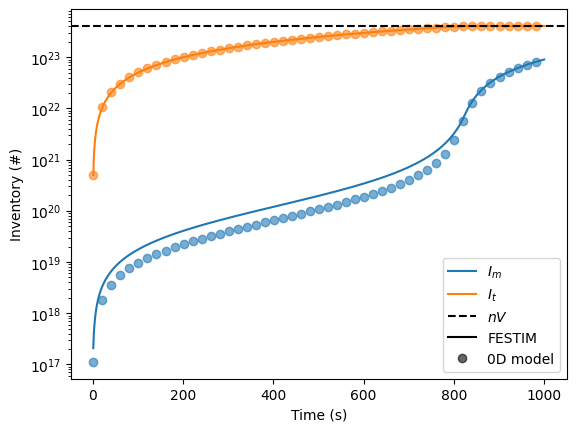

In [3]:

# Plot results

plt.figure()
plt.plot(
    total_solute.t,
    np.array(total_solute.data) * cross_sectional_area,
    color="tab:blue",
    label="$I_m$",
)
plt.plot(
    total_trapped.t,
    np.array(total_trapped.data) * cross_sectional_area,
    color="tab:orange",
    label="$I_t$",
)

plt.axhline(n * V, color="black", linestyle="--", label="$nV$")

plt.scatter(res.t, res.y[0], color="tab:blue", alpha=0.6)
plt.scatter(res.t, res.y[1], color="tab:orange", alpha=0.6)
plt.yscale("log")
plt.xlabel("Time (s)")
plt.ylabel("Inventory (#)")


custom_elements = [
    Line2D([0], [0], color="black", label="FESTIM"),
    Line2D(
        [0], [0], marker="o", linestyle="", color="black", label="0D model", alpha=0.6
    ),
]
# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles + custom_elements)
plt.savefig('only_intrinsic.png', dpi=300)
plt.show()
